In [188]:
pwd

u'/home/kangik/Dropbox/project/2017_DKI/script'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx

# import 
import pandas as pd
import numpy as np
import nibabel as nb
import os
from os.path import join, basename, dirname, abspath
import re

%matplotlib inline

In [6]:
# change here
dataLoc = '/Volume/CCNC_BI_3T/kcho/allData'
subjects = [x for x in os.listdir(dataLoc) if \
            x.startswith('NOR') or\
            x.startswith('CHR') or\
            x.startswith('FEP')]

In [9]:
mycmap = plt.cm.get_cmap('jet')
mycmap.set_under('magenta', alpha=0)

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

def get_cdict_cmaps(icNum):
    cmaps=get_cmap(icNum+1)
    
    # make colormaps
    cmap_dict = {}
    # make zero to be white
    cmap_dict[0]= (1, 1, 1, 0)

    for compNum in range(icNum):
        col = cmaps(compNum)
        cmap_dict[compNum+1] = col
        
    cmaps = colors.ListedColormap(cmap_dict.values())
    return cmap_dict, cmaps


def get_biggest_loc_fs(subject, side):
    return abspath(join(dataLoc, subject, 'segmentation_fnirt', side, 'biggest.nii.gz'))

def get_bg_T1_fs(subject):
    return abspath(join(dataLoc, subject, 'FREESURFER/mri/brain.nii.gz'))

def get_map(imgLoc):
    return nb.load(imgLoc).get_data()

def show_segmentation(subject):
    # load maps
    t1Map = get_map(get_bg_T1_fs(subject))
    leftSeg = get_map(get_biggest_loc_fs(subject, 'left'))
    rightSeg = get_map(get_biggest_loc_fs(subject, 'right'))    
    
    # left and right segmentation image merge
    seg_map = leftSeg + rightSeg
    
    # min/max x,y,z coordinate
    xcoords, ycoords, zcoords = seg_map.nonzero()    
    
    max_xcoord = xcoords.max()
    max_ycoord = ycoords.max() 
    max_zcoord = zcoords.max()
    
    min_xcoord = xcoords.min()
    min_ycoord = ycoords.min() 
    min_zcoord = zcoords.min()
    
    #fig, axes = plt.subplots(nrows=rowNum, ncols=colNum, figsize=(10,10))
    nrows = 3
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,10))
    
    cmap_dict, cmaps = get_cdict_cmaps(8)

    max2dVol = 0
    maxSlice = 0
    for zNum in range(leftSeg.shape[-1]):
        twoDvol_left = np.count_nonzero(leftSeg[:,:,zNum])
        twoDvol_right = np.count_nonzero(rightSeg[:,:,zNum])
        
        twoDvol = twoDvol_left + twoDvol_right
        if twoDvol > max2dVol:
            maxSlice = zNum
            max2dVol = twoDvol
    
    layer_name_dict = {1:'LPFC',
                       2:'LTC',
                       3:'MPFC',
                       4:'MTC',
                       5:'OCC',
                       6:'OFC',
                       7:'PC',
                       8:'SMC'}
    
    zGap = max_zcoord - min_zcoord
    increasement = zGap / (nrows + ncols + 3) # added 3 : removes each z-ends from showing
    
    z_slice = min_zcoord + increasement
    for ax in np.ravel(axes):
        ax.imshow(np.flipud(t1Map[min_xcoord-10:max_xcoord+10,
                                  min_ycoord-10:max_ycoord+10,
                                  z_slice].T), 
                  cmap='gray')
        seg_img = ax.imshow(np.flipud(seg_map[min_xcoord-10:max_xcoord+10,
                                              min_ycoord-10:max_ycoord+10,
                                              z_slice].T), 
                            cmap = cmaps, 
                            alpha=1)
        z_slice+=increasement

    legend_patches = [mpatches.Patch(color=cmap_dict[i], label=layer_name_dict[i]) for i in np.arange(1,9)]
    plt.legend(handles=legend_patches,
              bbox_to_anchor=(1.05, 1), loc=2)
#     axes[0,1].set_title(subject, fontsize=20)
    plt.savefig(subject+'.png')


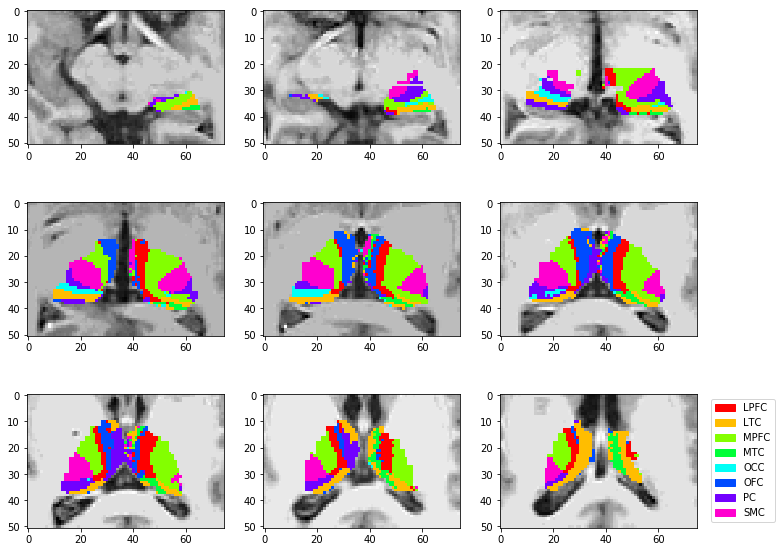